### Prueba 1 - Hito 2 - Javier Rojas Benitez - G56

In [76]:
import importlib

import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 10)


In [44]:
df = pd.read_csv("input/training_tweets.csv").drop(columns="Unnamed: 0")

# Preprocesamiento

## Variables independientes

In [45]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

STOPWORDS_INGLES = set(stopwords.words("english"))

In [46]:
def preprocesar_texto_lema(texto):
    tokens = texto.split()
    filtro_stop_words = [palabra for palabra in tokens if palabra not in STOPWORDS_INGLES]
    lematizacion = [lemmatizer.lemmatize(palabra, "v") for palabra in filtro_stop_words]

    texto_juntado = " ".join(lematizacion)

    return texto_juntado


def preprocesar_texto_stem(texto):
    tokens = texto.split()
    filtro_stop_words = [palabra for palabra in tokens if palabra not in STOPWORDS_INGLES]
    stemmizacion = [stemmer.stem(palabra, "v") for palabra in filtro_stop_words]

    texto_juntado = " ".join(stemmizacion)

    return texto_juntado

In [47]:
df["procesados_lema"] = df.content.str.lower().apply(preprocesar_texto_lema)
df["procesados_stem"] = df.content.str.lower().apply(preprocesar_texto_stem)

In [86]:
def analizar_frecuencias_palabras(serie_de_texto, strip_accents=None):
    vectorizer = CountVectorizer(strip_accents=strip_accents)

    matriz = vectorizer.fit_transform(serie_de_texto)
    palabras_vectorizador = vectorizer.vocabulary_
    df_conteo_palabras = (
        pd.DataFrame(
            palabras_vectorizador.values(), index=palabras_vectorizador.keys(), columns=["conteo"]
        )
        .sort_values(by="conteo", ascending=False)
        .reset_index(names="palabra")
    )

    return vectorizer, matriz, palabras_vectorizador, df_conteo_palabras

In [49]:
vect_lema, matriz_lema, dict_lema, df_lema = analizar_frecuencias_palabras(df["procesados_lema"])
vect_stem, matriz_stem, dict_stem, df_stem = analizar_frecuencias_palabras(df["procesados_stem"])


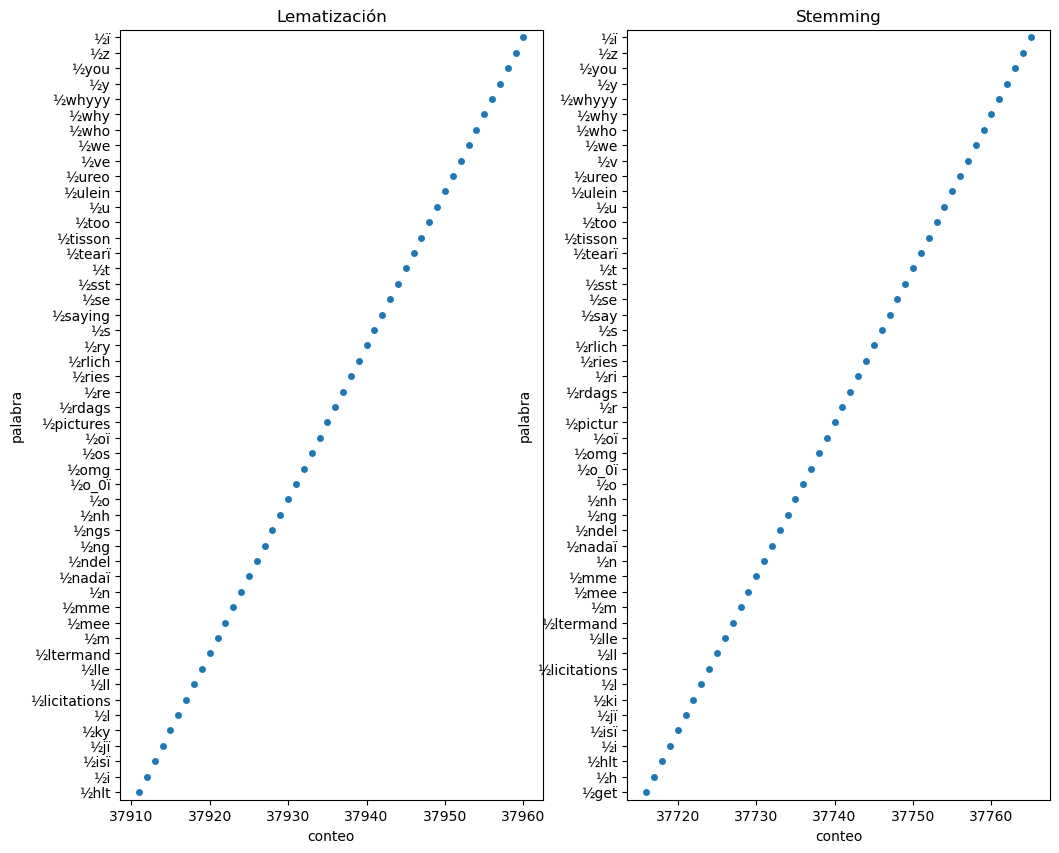

In [92]:
figure, axis = plt.subplots(1, 2, figsize=(12, 10))

sns.stripplot(data=df_lema.head(50), x="conteo", y="palabra", ax=axis[0])
sns.stripplot(data=df_stem.head(50), x="conteo", y="palabra", ax=axis[1])
axis[0].set_title("Lematización")
axis[1].set_title("Stemming")
plt.show()


- El preprocesamiento de texto con lematización y stemming genera una matriz de palabras similares (las 18 palabras más frecuentes  tienen la misma raíz )

- Las 50 palabras más frecuentes de la lematización y el stemming contienen carácteres mal leídos
(representados con 1/2). Debido a lo anterior, se realizará una tokenización con el parámetro
de CountVectorizer strip_accents='ascii'.